# Functional Encryption - Classification and information leakage

### Purpose

We want to train the model on the following task: given two images with the same character, but with two different fonts, can an adversarial model guess with a good accuracy which image has been selected by a challenger which only expose the output of the private model fed with a chosen image?

We would know train the CL model to address this specific detection task. As reducing the dataset to two fonts + one unique character would make the subset too small (~920 items), we will fix them in advance using "typical" fonts and character and make a complete dataset out of it, reusing Part1. "Typicalness" for font is measured on results of Part 9 and for characters on the confusion matrix of Part 4.

The fonts kepts are [1, 3] = cursive, Georgia and letter "p".

_We will also try fantasy, Arial which is a bit harder_

# 0. Build the dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from string import ascii_lowercase
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import torch.utils.data as utils
import pickle

## 0.1 Fonts

We choose 5 fonts that we believe to be reasonably distinguishable:

In [2]:
families = ['cursive', 'Georgia']

Here what they look like!

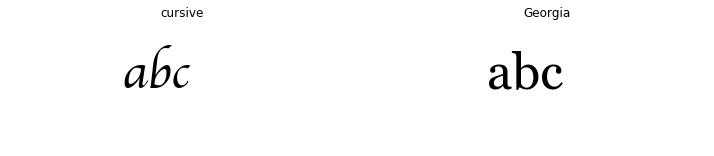

In [3]:
plt.figure(figsize=(12,2))
for i, family in enumerate(families):
    ax = plt.subplot(1, len(families), i+1)
    ax.set_title(family)
    ax.text(0.3, 0.4, 'abc', size=50, family=family)

    # Rm axes, draw and get the rgba shape of the letter
    plt.axis('off')
plt.show()

## 0.2 Noising process
Our dataset is artificial. Hence we need to add some noise to make it more interesting for a classification task.
Currently the noise boils down to:

 - A random but moderate rotation
 - A random but moderation size variation
 - A deformation using a Gaussian filter

When we are done, we recenter the data (as it is done for MNIST).

Let's do it for one character to see how it looks like!

In [4]:
# First we build a dict to map numbers to letters 
letters = {index: letter for index, letter in enumerate(ascii_lowercase)} 

### Utils functions to handle rgb / rgba conversion

In [5]:
def rgba_to_rgb(rgba):
        if rgba[0] > 0:
            return np.ones(3) * (256 - rgba[0])
        return rgba[1:]
    
def convert_to_rgb(data):
    return np.apply_along_axis(rgba_to_rgb, 2, data) 

### Deformation function

In [6]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

### Recentering function

In [7]:
def center(data):
    # Inverse black and white
    wb_data = np.ones(data.shape) * 255 - data
    
    # normalize
    prob_data = wb_data / np.sum(wb_data)
    
    # marginal distributions
    dx = np.sum(prob_data, (1, 2))
    dy = np.sum(prob_data, (0, 2))

    # expected values
    (X, Y, Z) = prob_data.shape
    cx = np.sum(dx * np.arange(X))
    cy = np.sum(dy * np.arange(Y))
    
    # Check bounds
    assert cx > X/4 and cx < 3 * X/4, f"ERROR: {cx} > {X/4} and {cx} < {3 * X/4}"
    assert cy > Y/4 and cy < 3 * Y/4, f"ERROR: {cy} > {Y/4} and {cy} < {3 * Y/4}"
    
    # print('Center', cx, cy)
    
    x_min = int(round(cx - X/4))
    x_max = int(round(cx + X/4))
    y_min = int(round(cy - Y/4))
    y_max = int(round(cy + Y/4))
    
    return data[x_min:x_max, y_min:y_max, :]
    

### One first example!

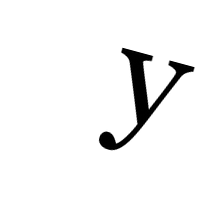

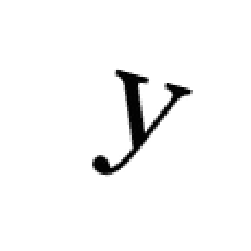

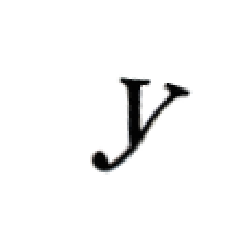

In [8]:
# Sample a rotation angle
rotation = np.random.normal(0, 10) # 10 degrees (out of 180)
# Sample a text size +/- 5% in std
size = 100 + np.random.normal(0, 5) 
# Sample a family
family_idx = np.random.randint(len(families))
family = families[family_idx]
# Sample a char
letter_idx = np.random.randint(26)
letter = letters[letter_idx]

# Show rotated letter
fig = plt.figure(figsize=(2,2), dpi=100)
fig.text(0.4, 0.4, letter, size=size, rotation=rotation, family=family)
plt.axis('off')
plt.show()
plt.close(fig)

# Load the letter in smaller size
fig = plt.figure(figsize=(2,2), dpi=100)
fig.text(0.4, 0.4, letter, size=50, rotation=rotation, family=family)

# Rm axes, draw and get the rgba shape of the letter
plt.axis('off')
fig.canvas.draw()
data = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (4,))
plt.close(fig)
# Convert to rgb
data = convert_to_rgb(data)

# Re-center the data
data = center(data)

plt.show()
plt.axis('off')
plt.imshow(data)
plt.show()

# Apply an elastic deformation
data = elastic_transform(data, alpha=991, sigma=9)

plt.axis('off')
plt.imshow(data)
plt.show()

# Free memory space
plt.close(fig)

Feel free to change the rotation std, the text size std, and the `alpha` and `sigma` parameters in the deformation. You'll see that the task can be made incredibly harder!

### Building the dataset
Ok now we are equipped to build a complete dataset!

In [9]:
# We define a variance parameter for rotation and one for text size
std_rotation = 10
std_size = 2.5 # 5% of reference size, here 50

In [10]:
def build_dataset(dataset_size, letters_choice, verbose=False):
    dataset_data = []
    dataset_target_char = []
    dataset_target_family = []
    for i in range(dataset_size):
        rotation = np.random.normal(0, std_rotation)
        size = 50 + np.random.normal(0, std_size) 
        family_idx = np.random.randint(len(families))
        family = families[family_idx]
        letter_idx = np.random.randint(len(letters_choice))
        letter = letters_choice[letter_idx]
        
        if i % int(dataset_size/100) == 0:
            print(round(i / dataset_size * 100), '%', letter)

        fig = plt.figure(figsize=(2,2), dpi=28)
        fig.text(0.4, 0.4, letter, size=size, rotation=rotation, family=family)

        # Rm axes, draw and get the rgba shape of the letter
        plt.axis('off')
        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (4,))

        # Convert to rgb
        data = convert_to_rgb(data)

        # Center the data
        data = center(data)

        if verbose:
            plt.show()
            plt.axis('off')
            plt.imshow(data)
            plt.show()
            
        # Apply an elastic deformation
        data = elastic_transform(data, alpha=991, sigma=9)

        if verbose:
            plt.axis('off')
            plt.imshow(data)
            plt.show()

        # Free memory space
        plt.close(fig)

        # Append data to the datasets
        target_char = np.array([letter_idx])
        target_family = np.array([family_idx])
        dataset_data.append(data[:,:,0])
        dataset_target_char.append(target_char)
        dataset_target_family.append(target_family)
        
    return dataset_data, dataset_target_char, dataset_target_family

In [11]:
letters_choice = letters

def save_dataset(info, data, target_char, target_family):
    with open('dataset/character_dataset_cursive_georgia_{}.pkl'.format(info), 'wb') as output:
        dataset = data, target_char, target_family
        pickle.dump(dataset, output, pickle.HIGHEST_PROTOCOL)

        
# We build 10000 per 10000 for memory purposes
# WARNING: This step takes time, and you may need to restart you notebook for memory purposes.
#for i in range(6):
#    print(f"Train{i}")
#    train_data, train_target_char, train_target_family = build_dataset(10000, letters_choice)
#    save_dataset(f"train{i}", train_data, train_target_char, train_target_family)
    
#print("Test")
#test_data, test_target_char, test_target_family = build_dataset(10000, letters_choice)
#save_dataset("test", test_data, test_target_char, test_target_family)

In [12]:
letters_choice = ['p']

def save_dataset(info, data, target_char, target_family):
    with open('dataset/character_dataset_cursive_georgia_p_{}.pkl'.format(info), 'wb') as output:
        dataset = data, target_char, target_family
        pickle.dump(dataset, output, pickle.HIGHEST_PROTOCOL)

        
# We build 10000 per 10000 for memory purposes
# WARNING: This step takes time, and you may need to restart you notebook for memory purposes.
for i in range(0):
    print(f"Train{i}")
    train_data, train_target_char, train_target_family = build_dataset(10000, letters_choice)
    save_dataset(f"train{i}", train_data, train_target_char, train_target_family)
    
print("Test")
test_data, test_target_char, test_target_family = build_dataset(10000, letters_choice)
save_dataset("test", test_data, test_target_char, test_target_family)

Test
0 % p
1 % p
2 % p
3 % p
4 % p
5 % p
6 % p
7 % p
8 % p
9 % p
10 % p
11 % p
12 % p
13 % p
14 % p
15 % p
16 % p
17 % p
18 % p
19 % p
20 % p
21 % p
22 % p
23 % p
24 % p
25 % p
26 % p
27 % p
28 % p
29 % p
30 % p
31 % p
32 % p
33 % p
34 % p
35 % p
36 % p
37 % p
38 % p
39 % p
40 % p
41 % p
42 % p
43 % p
44 % p
45 % p
46 % p
47 % p
48 % p
49 % p
50 % p
51 % p
52 % p
53 % p
54 % p
55 % p
56 % p
57 % p
58 % p
59 % p
60 % p
61 % p
62 % p
63 % p
64 % p
65 % p
66 % p
67 % p
68 % p
69 % p
70 % p
71 % p
72 % p
73 % p
74 % p
75 % p
76 % p
77 % p
78 % p
79 % p
80 % p
81 % p
82 % p
83 % p
84 % p
85 % p
86 % p
87 % p
88 % p
89 % p
90 % p
91 % p
92 % p
93 % p
94 % p
95 % p
96 % p
97 % p
98 % p
99 % p


Ok we now have our dataset! Let's use it!

### Conclusion

We use it now in part 21 bis to make a CL task which is quite close to what we've been doing previously, except that:
- Training is now done with arbitrary chars and 2 fonts
- Collateral Learning is done with a selected char and 2 fonts

### Appendix
Here is an utility function to draw some samples of the dataset

In [13]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))
import random, math
import learn
data = learn.load_data()
train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data

Training set 60000 items
Testing set  10000 items


IndexError: list index out of range

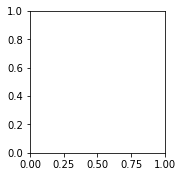

In [14]:
def show_examples(data, target_char, target_family, n_examples=20):
    n_rows = math.ceil(n_examples / 5)
    plt.figure(figsize=(14, 3*n_rows))
    for i in range(n_examples):
        ax = plt.subplot(n_rows, 5, i+1)
        idx = random.randint(0, len(data))
        image = data[idx]
        letter = letters[target_char[idx][0]]
        family = families[target_family[idx][0]]
        ax.set_title(f"{letter} ({family})")
        plt.axis('off')
        ax.imshow(image, cmap='gist_gray')
    plt.show()
        
        
show_examples(test_data, test_target_char, test_target_family)